# Train without normalize
# Train with datasets: KuHar and CHARM
# Test with dataset: MotionSense

1. Apply DFT over dataset windows and universal UMAP
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score

# Crossvalidation experiments with KuHar and CHARM as base and MotionSense as target

This notebook will perform crossvalidation experiments using the KuHar and CHARM datasets at 20 Hz as training dataset. It will contain the following steps:

1. Quick load train, test and validation CSV subsets from the balanced KuHar and MotionSense datasets at 20 Hz using `PandasDatasetsIO` helper
2. Quick load train, test and validation CSV subsets from other relevant datasets using `PandasDatasetsIO` helper
3. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
4. Apply the fourier transform on Charm
5. Apply universal UMAP
6. Train SVM, KNN and Random Forest classification models on the KuHar and MotionSense dataset in the frequency domain with dimensionality reduction
7. Evaluate SVM, KNN and Random Forest classification models on Charm in the frequency domain with dimensionality reduction

The experiments will evaluate the performance of SVM, KNN and RF models trained on a balanced KuHar and MotionSense datasets and tested on Charm in the frequency domain with dimensionality reduction.

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, CHARMUnbalancedView, KuHarResampledView20HZ, MotionSenseResampledView20HZ

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-03 14:27:45.497964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 14:27:45.498044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensoryBalancedResampledView20HZ("../../../../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False)
train_val_es, test_es = loader.load(concat_train_validation=True)
# X_ es = train_val_es.data.iloc
# X_es = train_val_es.data.iloc[:,1:-6]


train_val_es.data.iloc[:,1:-6]

,accelerometer-x-0,accelerometer-x-1,accelerometer-x-2,accelerometer-x-3,accelerometer-x-4,accelerometer-x-5,accelerometer-x-6,accelerometer-x-7,accelerometer-x-8,accelerometer-x-9,...,gyroscope-z-50,gyroscope-z-51,gyroscope-z-52,gyroscope-z-53,gyroscope-z-54,gyroscope-z-55,gyroscope-z-56,gyroscope-z-57,gyroscope-z-58,gyroscope-z-59
0,-0.724789,-0.507973,0.107924,-0.052122,-0.308210,-0.327109,-0.144647,-0.061857,-0.075849,-0.108986,...,-0.029486,0.011534,-0.032998,0.016543,-0.041989,0.027790,-0.045943,0.052013,-0.077395,0.111475
1,-0.013220,-0.019134,-0.002889,-0.008703,0.013098,0.018542,0.009620,0.016564,0.006461,0.004548,...,0.000029,0.004917,-0.018431,0.004122,0.019265,0.014980,0.022228,0.023919,0.028533,0.013692
2,-0.214355,-0.206973,-0.219664,-0.225939,-0.219012,-0.208570,-0.195748,-0.212864,-0.227196,-0.245031,...,0.002744,0.005068,0.010737,0.009596,0.007746,0.004763,0.013354,0.005289,0.002381,0.008331
3,0.761069,0.757731,0.752873,0.753823,0.753913,0.756301,0.758194,0.756618,0.756947,0.756485,...,0.001041,-0.000783,-0.002598,0.001302,0.000400,0.000531,-0.002842,0.000469,0.000963,-0.001895
4,-0.001454,-0.008433,-0.004865,-0.006524,-0.005949,-0.006001,-0.007217,-0.008985,-0.007185,-0.003809,...,-0.001976,-0.000086,-0.000245,0.001119,-0.001033,0.001574,-0.001405,-0.000204,-0.003032,0.002380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.318814,0.820496,0.829511,1.464799,1.194766,1.340308,0.655106,0.642922,1.672151,1.631894,...,-0.071705,0.560008,0.477855,0.188169,0.514792,-0.305859,-0.512085,-0.384287,-0.300596,-0.197638
140,-3.755993,-2.862513,-2.130942,1.607675,3.116307,2.871448,1.015326,3.089434,5.513042,4.221506,...,-1.275709,-2.031439,-3.953223,-4.451037,-2.519823,-1.071030,-2.209544,-2.579949,-0.775481,0.184701
141,-0.046923,-0.052641,-0.047726,-0.048309,-0.047292,-0.043157,-0.039521,-0.041308,-0.040168,-0.044390,...,-0.006601,-0.004064,0.002956,0.005797,0.001869,-0.003331,0.004593,-0.004651,0.003989,-0.001190
142,-6.725034,-4.565210,-6.688427,-8.245128,-2.401993,6.173494,6.665963,7.925987,2.102236,-0.814744,...,7.413526,2.151802,-1.035741,0.370291,-0.468816,-1.549655,-2.854839,-5.031104,-7.418414,-6.967641


In [4]:
# Train set
extrasensory_train_X = np.array(train_val_es.data.iloc[:,1:-6])
extrasensory_train_Y = np.array(train_val_es.data['activity code'])
tam = len(extrasensory_train_Y)
extrasensory_train_id_dataset = np.array(['E']*tam)

In [5]:
# Teste set
extrasensory_test_X = np.array(test_es.data.iloc[:,1:-6])
extrasensory_test_Y = np.array(test_es.data['activity code'])
tam = len(extrasensory_test_Y)
extrasensory_test_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [6]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../../data/views/UCI-HAR/unbalanced_view_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)

train_val_uci.data['activity code'] = train_val_uci.data['activity code'].astype('int')

In [7]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_uci = transformer(train_val_uci)
test_uci = transformer(test_uci)

# Train set
uci_train_X = train_val_uci.X
uci_train_Y = train_val_uci.y

tam = len(uci_train_Y)
uci_train_id_dataset = np.array(['U']*tam)

In [8]:
# Test set

uci_test_X = test_uci.X
uci_test_Y = test_uci.y

tam = len(uci_test_Y)
uci_test_id_dataset = np.array(['U']*tam)

## Load WISDM

In [9]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../../data/views/WISDM/interpolated_unbalanced_view_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
train_val_wisdm.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_wisdm.data['activity code'] = train_val_wisdm.data['activity code'].astype('int')


In [10]:
# Train set
wisdm_train_X = np.array(train_val_wisdm.data.iloc[:,:-2])
wisdm_train_Y = np.array(train_val_wisdm.data['activity code'])

tam = len(wisdm_train_Y)
wisdm_train_id_dataset = np.array(['W']*tam)

In [11]:
# Test set
wisdm_test_X = np.array(test_wisdm.data.iloc[:,:-2])
wisdm_test_Y = np.array(test_wisdm.data['activity code'])

tam = len(wisdm_test_Y)
wisdm_test_id_dataset = np.array(['W']*tam)

## Concatenate datasets

In [12]:
columns = list(train_val_wisdm.data.iloc[:,:-2].columns)
train_val_es.window_names, train_val_uci.window_names, train_val_wisdm.window_names

(['accelerometer-x',
  'accelerometer-y',
  'accelerometer-z',
  'gyroscope-x',
  'gyroscope-y',
  'gyroscope-z'],
 ['resampled.accel-x',
  'resampled.accel-y',
  'resampled.accel-z',
  'resampled.gyro-x',
  'resampled.gyro-y',
  'resampled.gyro-z'],
 ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'])

In [13]:
train_universal_X = np.concatenate([wisdm_train_X, uci_train_X, extrasensory_train_X])
test_universal_X = np.concatenate([wisdm_test_X, uci_test_X, extrasensory_test_X])

train_universal_X.shape, test_universal_X.shape

((14016, 360), (5645, 360))

In [14]:
train_universal_Y = np.concatenate([wisdm_train_Y, uci_train_Y, extrasensory_train_Y])
test_universal_Y = np.concatenate([wisdm_test_Y, uci_test_Y, extrasensory_test_Y])

train_universal_Y.shape, test_universal_Y.shape

((14016,), (5645,))

In [15]:
train_universal_id_dataset = np.concatenate([wisdm_train_id_dataset, uci_train_id_dataset, extrasensory_train_id_dataset])
test_universal_id_dataset = np.concatenate([wisdm_test_id_dataset, uci_test_id_dataset, extrasensory_test_id_dataset])

In [16]:
train_universal = pd.DataFrame(train_universal_X, columns=columns)
train_universal['Id Dataset'] = train_universal_id_dataset

test_universal = pd.DataFrame(test_universal_X, columns=columns)
test_universal['Id Dataset'] = test_universal_id_dataset

In [17]:
# Preaper the train and test universal datasets
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_universal = PandasMultiModalDataset(
    train_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Test
test_universal = PandasMultiModalDataset(
    test_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

## Train universal UMAP

In [18]:
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

# Transform it and generate a new dataset!
train_universal_fft = transformer(train_universal)
test_fft = transformer(test_universal)

umap = UMAP(n_components=10, random_state=42)
umap.fit(train_universal_fft[:][0])

UMAP(n_components=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

# Datasets to evaluate the manifold

## Load KuHar

In [19]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
loader = KuHarResampledView20HZ("../../../../../data/views/KuHar/balanced_motionsense_equivalent_view", download=False)
train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [20]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_kh = transformer(train_val_kh)
test_kh = transformer(test_kh)

In [21]:
# Train Set
kuhar_train_X = train_val_kh.X
kuhar_train_Y = train_val_kh.y
tam = len(kuhar_train_Y)
kuhar_train_id_dataset = np.array(['K']*tam)

In [22]:
# Train Set
kuhar_test_X = test_kh.X
kuhar_test_Y = test_kh.y
tam = len(kuhar_test_Y)
kuhar_test_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [23]:
loader = MotionSenseResampledView20HZ("../../../../../data/views/MotionSense/resampled_view_20Hz", download=False)
train_val_motion, test_motion = loader.load(concat_train_validation=True)

In [24]:
train_val_motion.data.iloc[:,1:-6]

,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,userAcceleration.x-9,...,rotationRate.z-50,rotationRate.z-51,rotationRate.z-52,rotationRate.z-53,rotationRate.z-54,rotationRate.z-55,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59
0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,-0.077553,...,0.338630,0.630162,0.010132,-0.357627,-0.270421,-0.099006,-0.171130,0.292608,0.932535,0.782147
1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,0.154172,...,-0.188645,0.175246,-0.369358,0.338468,-0.711659,-0.838042,0.241819,0.718420,0.336507,0.936563
2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,0.016328,...,0.105371,0.025860,1.168944,0.831773,-0.490816,0.497304,0.732298,0.667477,-0.025386,-0.037093
3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,0.440440,...,-2.477212,-1.612381,-0.416034,0.802364,0.116252,0.919908,0.037076,-0.993926,-0.182277,0.317828
4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,-0.009679,...,-0.533618,-0.931536,-0.890335,-0.515152,-0.552368,-0.060734,0.496173,1.265226,1.502311,0.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,-0.007693,0.374393,-0.103716,0.514280,0.141910,0.196481,0.390237,-1.349047,-0.513315,0.040985,...,0.332628,-0.564182,1.271037,2.880865,2.318440,0.053538,-0.589413,-1.091889,1.141263,-0.552978
4016,-0.785497,-0.465941,1.356811,-0.254648,-1.731042,-0.297563,1.190248,-1.193936,0.560628,0.325113,...,-2.720648,-1.525806,-0.443669,0.836655,1.793170,2.214804,2.611230,1.658511,1.304156,-2.120086
4017,0.892239,0.629815,0.395018,-0.061029,0.418810,0.094484,0.048136,-1.074050,0.657432,0.022222,...,1.203391,0.940672,1.160005,0.241466,-1.654988,-0.728725,1.016603,-1.277840,-2.122599,-1.689117
4018,-0.136312,-0.461621,-0.561228,-0.670517,0.174832,-0.068340,-0.384419,-0.207647,0.030618,-0.006123,...,-0.281189,-0.078258,0.658548,1.646081,1.596760,1.686676,1.358415,1.432210,0.481120,-2.242066


In [25]:
# Train set
motion_train_X = np.array(train_val_motion.data.iloc[:,1:-6])
motion_train_Y = np.array(train_val_motion.data['normalized activity code'])
tam = len(motion_train_Y)
motion_train_id_dataset = np.array(['M']*tam)

In [26]:
# Test set
motion_test_X = np.array(test_motion.data.iloc[:,1:-6])
motion_test_Y = np.array(test_motion.data['normalized activity code'])
tam = len(motion_test_Y)
motion_test_id_dataset = np.array(['M']*tam)

## Load CHARM

In [27]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../../../data/views/CHARM/unbalanced_view_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
#train_val.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_charm.data['activity code'] = train_val_charm.data['activity code'].astype('int')

In [28]:
#Selecting only classes of interest
train_val_charm.data = train_val_charm.data[train_val_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]
test_charm.data = test_charm.data[test_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]

# 0: "Sitting in a Chair", 
# 2: "Standing", 
# 6: "Walking", 
# 7: "Running", 
# 8: "Walking Upstairs", 
# 9: "Walking Downstairs"

In [29]:
train_val_charm.data.loc[train_val_charm.data['activity code'] == 0, 'activity code'] = 0
train_val_charm.data.loc[train_val_charm.data['activity code'] == 2, 'activity code'] = 1
train_val_charm.data.loc[train_val_charm.data['activity code'] == 6, 'activity code'] = 2
train_val_charm.data.loc[train_val_charm.data['activity code'] == 7, 'activity code'] = 5
train_val_charm.data.loc[train_val_charm.data['activity code'] == 8, 'activity code'] = 3
train_val_charm.data.loc[train_val_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [30]:
test_charm.data.loc[test_charm.data['activity code'] == 0, 'activity code'] = 0
test_charm.data.loc[test_charm.data['activity code'] == 2, 'activity code'] = 1
test_charm.data.loc[test_charm.data['activity code'] == 6, 'activity code'] = 2
test_charm.data.loc[test_charm.data['activity code'] == 7, 'activity code'] = 5
test_charm.data.loc[test_charm.data['activity code'] == 8, 'activity code'] = 3
test_charm.data.loc[test_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [31]:
test_charm.data.iloc[:,:-2]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,1.879448,1.500681,-1.174169,-1.630500,-0.099836,0.597497,-0.103199,-1.061374,-2.035104e-01,0.931233,...,7.464156,7.526118,7.610852,7.690204,7.743561,7.768027,7.763106,7.728302,7.663215,7.571209
1,0.011971,0.096702,-0.042733,0.079931,0.047884,0.121492,-0.042865,0.067758,8.501802e-07,-0.394896,...,7.537324,7.551921,7.563939,7.569555,7.565093,7.552101,7.538564,7.532864,7.543381,7.576013
2,0.064720,0.101952,0.106021,0.099464,0.114984,0.089651,0.057067,0.086416,4.653369e-02,0.017879,...,7.596793,7.540030,7.485392,7.458254,7.468905,7.495811,7.513399,7.507430,7.505726,7.522257
3,0.143652,0.114068,0.104190,0.099443,0.081403,0.118386,0.115311,0.092937,1.987187e-01,0.086573,...,7.478630,7.448785,7.464705,7.503505,7.547525,7.590124,7.626060,7.650090,7.656973,7.641466
4,0.239420,-0.119342,0.222922,0.227157,0.230869,0.210684,-0.047215,-0.043566,-5.267240e-02,-0.005764,...,7.398662,7.440133,7.402848,7.433113,7.529797,7.656387,7.776371,7.843522,7.777644,7.591982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-0.967297,-0.904365,-0.491548,-0.349609,-0.255211,-0.218702,-0.064379,0.195237,-6.829680e-01,-0.804258,...,9.015866,8.990211,8.965254,8.941047,8.917637,8.895075,8.873409,8.852688,8.832961,8.814279
743,-0.593638,-0.254300,-0.152600,-0.030320,0.137307,-0.270682,-0.129898,-0.569453,-5.696658e-01,-0.300620,...,9.677094,9.702890,9.727524,9.750908,9.772955,9.793576,9.812683,9.830190,9.846007,9.860048
744,-0.474044,-0.398683,-0.436124,-0.337572,-0.441708,-0.294742,-0.542583,-0.427829,-7.259730e-03,0.112430,...,8.445660,8.466347,8.490395,8.517407,8.546990,8.578746,8.612282,8.647202,8.683111,8.719614
745,-1.247899,-0.850150,-1.352727,0.112613,-1.459835,-2.899197,-0.724845,-1.209904,-9.698346e-01,-1.278050,...,9.214954,9.043058,8.915422,8.826874,8.772245,8.746366,8.744065,8.760173,8.789520,8.826937


In [32]:
# Train set
charm_train_X = np.array(train_val_charm.data.iloc[:,:-2])
charm_train_Y = np.array(train_val_charm.data['activity code'])
tam = len(charm_train_Y)
charm_train_id_dataset = np.array(['C']*tam)

In [33]:
# Test set
charm_test_X = np.array(test_charm.data.iloc[:,:-2])
charm_test_Y = np.array(test_charm.data['activity code'])
tam = len(charm_test_Y)
charm_test_id_dataset = np.array(['C']*tam)

## Prepare train and test datas

In [34]:
# train_X = np.concatenate([charm_train_X, motion_train_X, kuhar_train_X])
# train_Y = np.concatenate([charm_train_Y, motion_train_Y, kuhar_train_Y])
# train_id_dataset = np.concatenate([charm_train_id_dataset, motion_train_id_dataset, kuhar_train_id_dataset])

# test_X = np.concatenate([charm_test_X, motion_test_X, kuhar_test_X])
# test_Y = np.concatenate([charm_test_Y, motion_test_Y, kuhar_test_Y])
# test_id_dataset = np.concatenate([charm_test_id_dataset, motion_test_id_dataset, kuhar_test_id_dataset])

In [35]:
train_X = np.concatenate([charm_train_X, kuhar_train_X])
train_Y = np.concatenate([charm_train_Y, kuhar_train_Y])
train_id_dataset = np.concatenate([charm_train_id_dataset, kuhar_train_id_dataset])

test_X = np.concatenate([motion_test_X])
test_Y = np.concatenate([motion_test_Y])
test_id_dataset = np.concatenate([motion_test_id_dataset])

In [36]:
# Train set to classifiers
train = pd.DataFrame(train_X, columns=columns)
train['normalized activity code'] = train_Y
train['Id Dataset'] = train_id_dataset

# Test set to classifiers
test = pd.DataFrame(test_X, columns=columns)
test['normalized activity code'] = test_Y
test['Id Dataset'] = test_id_dataset

In [37]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

# Test
test = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

# Evaluate the manifold

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


One transformers will be created:

- `fft_transform`: Apply the transforms over windows of the dataset

In [38]:
# Create the objects
umap_transform = WindowedTransform(
   transform=umap, fit_on=None, transform_on="all")

fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform, 
                umap_transform], new_window_name_prefix="reduced."
)

In [39]:
# Transform it and generate a new dataset!
train_reduced = transformer(train)
test_reduced = transformer(test)

In [40]:
# Checking the whole data...
train_reduced[:][0]

array([[ 5.000567  ,  5.2702823 ,  2.4315026 , ...,  2.4326704 ,
         4.8449545 ,  4.8424172 ],
       [ 8.523737  ,  5.032132  ,  4.902791  , ...,  5.981824  ,
         4.811744  , -0.48426905],
       [ 8.610521  ,  5.018275  ,  4.917923  , ...,  5.99248   ,
         4.812843  , -0.5904058 ],
       ...,
       [10.41476   ,  5.09778   ,  2.5414293 , ...,  4.185995  ,
        14.033433  ,  7.9192615 ],
       [ 5.429549  ,  5.789268  ,  2.1297047 , ..., 10.468501  ,
         6.7231812 ,  5.616984  ],
       [10.1969795 ,  5.2192507 ,  2.4523778 , ...,  4.4136825 ,
        13.999502  ,  8.356666  ]], dtype=float32)

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [41]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

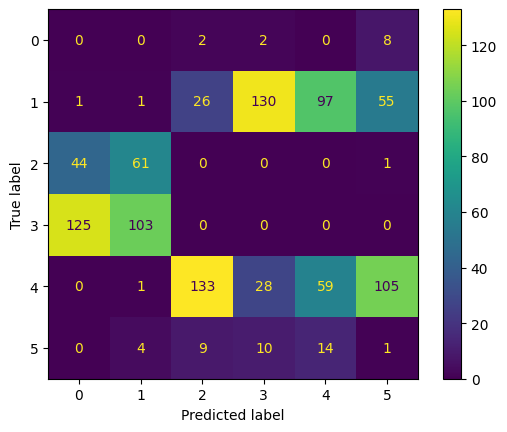

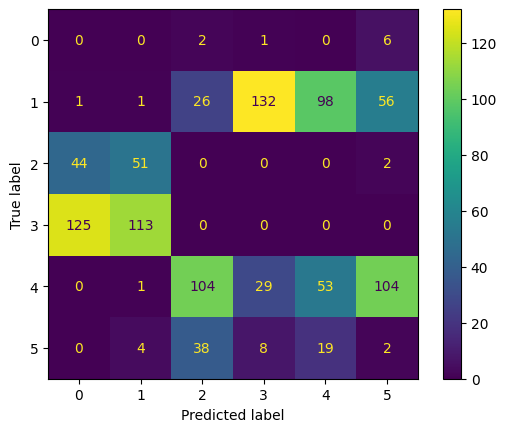

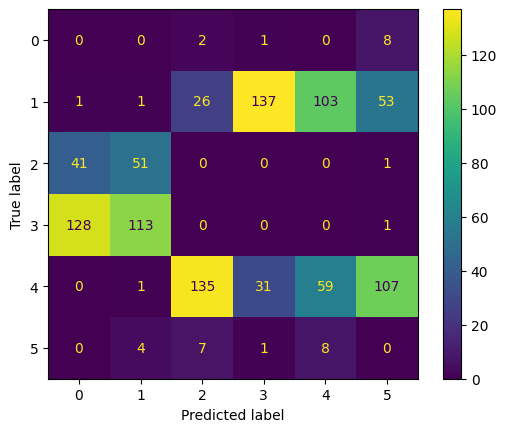

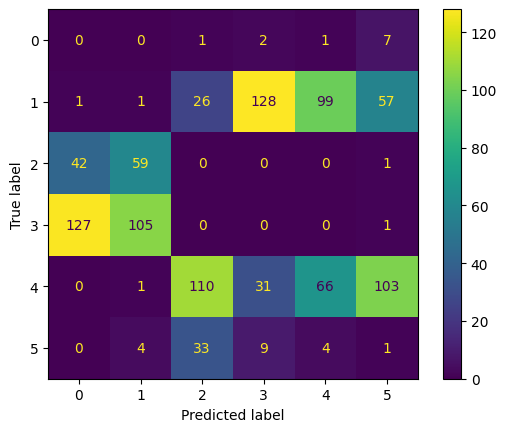

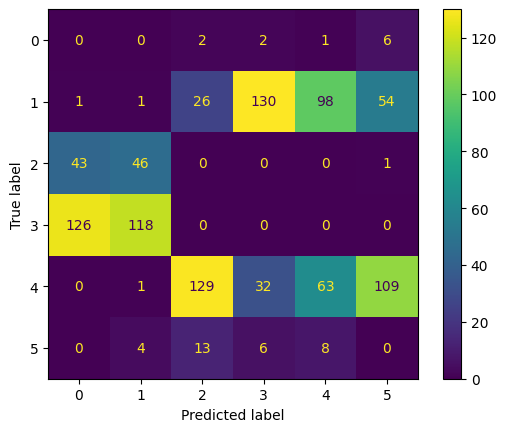

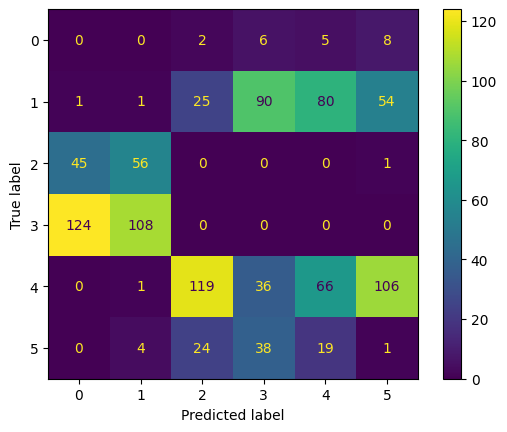

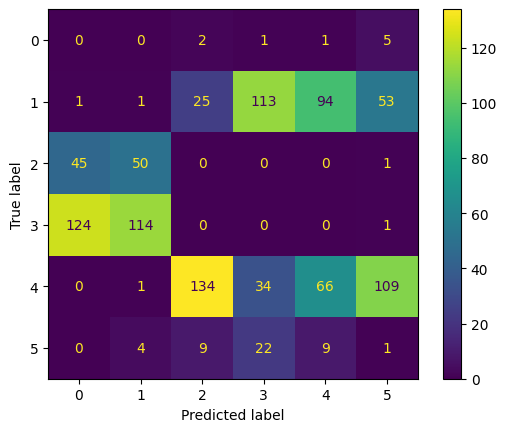

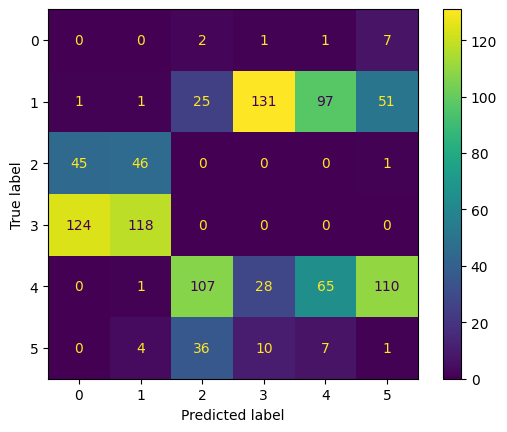

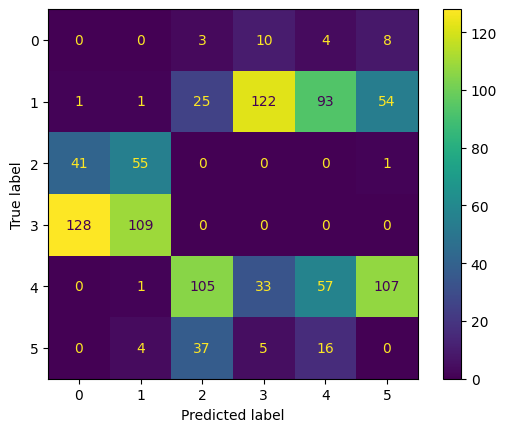

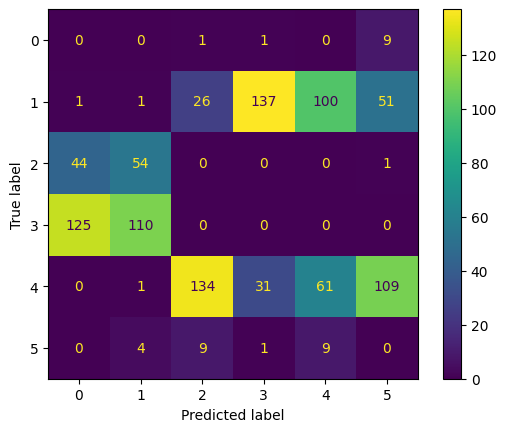

Mean accuracy (10 runs): 0.0620. Mean f1-score: 0.0805.Std accuracy (10 runs): 0.0042. Std f1-score: 0.0061


In [42]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### SVM

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


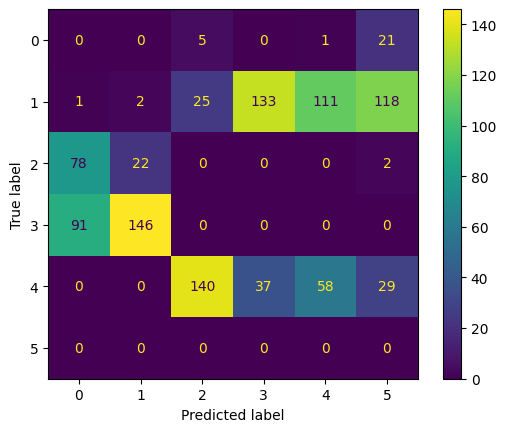

Mean accuracy (1 runs): 0.0588. Mean f1-score: 0.0719.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [43]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### KNN

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


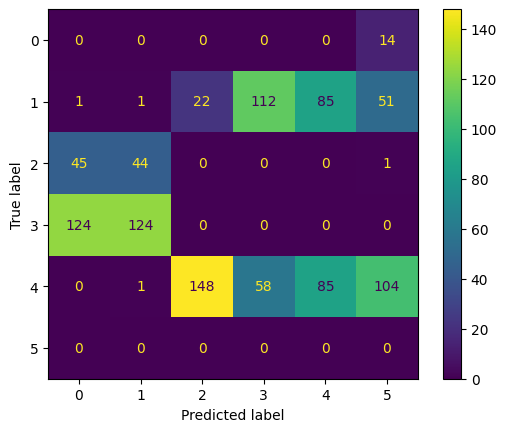

Mean accuracy (1 runs): 0.0843. Mean f1-score: 0.1178.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [44]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [45]:
# def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
#     fig, ax = plt.subplots(figsize=figsize)
#     for label, group_df in df.groupby("label"):
#         label = labels[label] if labels is not None else label
#         ax.scatter(group_df.x, group_df.y, label=label)
#     ax.legend()
#     plt.title(title)
#     plt.show()

In [46]:
# labels = {0: "Sitting in a Chair", 1: "Sitting in a Couch", 2: "Standing", 3: "Lying up", 4: "Lying side", 5: "Device on surface",
# 6: "Walking", 7: "Running", 8: "Walking Upstairs", 9: "Walking Downstairs"}
# print(labels)

In [47]:
# labels = {'K': 'KuHar', 
#           'M': 'MotionSense',
#           'C': 'CHARM',
#           'E': 'ExtraSensory',
#           'W': 'WISDM',
#           'U': 'UCI',
#          }

# # KuHAR	K
# # MotionSense	M
# # CHARM	C
# # ExtraSensory	E
# # WISDM	W
# # UCI	U

### UMAP

In [48]:
# model = UMAP(n_components=2, random_state=42)
# result = pd.DataFrame(model.fit_transform(train_universal_fft[:][0]), columns=["x", "y"])
# result["label"] = train_universal_fft[:][1]
# plot(result, title="UMAP on ExtraSensory, UCI-HAR, and WISDM FFT data", labels = labels)

In [49]:
# # model = UMAP(n_components=2)
# result = pd.DataFrame(model.transform(test_fft[:][0]), columns=["x", "y"])
# result["label"] = test_fft[:][1]
# plot(result, title="UMAP projection on KuHar, MotionSense, and CHARM FFT data", labels = labels)

### T-SNE

In [50]:
# model = TSNE(n_components=2, random_state=42)
# result = pd.DataFrame(model.fit_transform(train_universal[:][0]), columns=["x", "y"])
# result["label"] = train_universal[:][1]
# plot(result, title="T-SNE on ExtraSensory, UCI-HAR, and WISDM FFT data", labels=labels)